In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
from scipy import stats

In [4]:
def filter_variables(df, dict_variables) :
    inicial = True
    for key in dict_variables.keys() :
        if type(dict_variables[key]) == str:
            if inicial :
                filtro = f"({key}\'{dict_variables[key]}\')"
                inicial = False
            else:
                filtro = filtro + f" and ({key}\'{dict_variables[key]}\')"
        else:
            if inicial :
                filtro = f"({key}{dict_variables[key]})"
                inicial = False
            else:
                filtro = filtro + f" and ({key}{dict_variables[key]})"

    return pd.DataFrame(df.query(filtro))

In [11]:
data = pd.read_csv('performances.csv')
data.shape

(20735, 14)

In [12]:
data.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
0,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,C,NaN,C,1,NaN,NaN,NaN
1,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,C,0,NaN,NaN,NaN
2,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN
3,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN
4,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN


In [13]:
training_dyads = filter_variables(data, {
    'treatment==':'dyad', 
    'stage==':'Training rounds'
})
training_dyads.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
10955,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,B,NaN,B,1,NaN,NaN,NaN
10956,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,D,NaN,B,0,NaN,NaN,NaN
10957,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,D,NaN,D,1,NaN,NaN,NaN
10958,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,B,NaN,D,0,NaN,NaN,NaN
10959,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,D,NaN,B,0,NaN,NaN,NaN


In [14]:
df_training = training_dyads.groupby(['dyad', 'player'])['accuracy'].mean().reset_index()
df_training.head()

,dyad,player,accuracy
0,10101-83343,101017895939220,0.941667
1,10101-83343,833437527724022,0.984000
2,12379-51238,123795257479166,0.958333
3,12379-51238,512381829158551,0.983333
4,13364-56585,56585762474570,0.966667


In [93]:
game_dyads = filter_variables(data, {
    'treatment==':'dyad', 
    'stage==':'Game rounds',
    'expert_dog==':False,
    'round<':4
})
game_dyads['queried'] = game_dyads['queried'].apply(lambda x: 1 if x>0 else 0)
game_dyads.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
11206,dyad,45981-38174,459819203408978,hound,terrier,Game rounds,1,C,False,A,0,0,NaN,NaN
11209,dyad,45981-38174,459819203408978,hound,terrier,Game rounds,1,A,False,C,0,0,NaN,NaN
11210,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,B,1,0,NaN,NaN
11212,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,D,0,0,NaN,NaN
11213,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,D,0,0,NaN,NaN


In [94]:
df_use = game_dyads.groupby(['round']).agg({'queried':['sum', 'count']}).reset_index()
df_use.columns = df_use.columns.get_level_values(0)
df_use.columns = ['round', 'sum', 'count']
df_use['use'] = df_use['sum'] / df_use['count']
df_use = df_use[['round', 'use']]
df_use.head()

,round,use
0,1,0.414286
1,2,0.455556
2,3,0.445652


<AxesSubplot:xlabel='round', ylabel='use'>

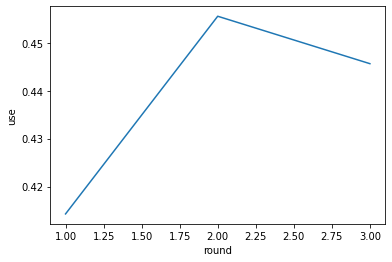

In [95]:
sns.lineplot(x='round', y='use', data=df_use)

In [96]:
df_use = game_dyads.groupby(['dyad', 'player']).agg({'queried':['sum', 'count'], 'novice_in':'unique'}).reset_index()
#df_use.columns = df_use.columns.get_level_values(0)
df_use.columns = ['dyad', 'player', 'sum', 'count', 'novice_in']
df_use['use'] = df_use['sum'] / df_use['count']
df_use['novice_in'] = df_use['novice_in'].apply(lambda x: x[0])
df_use = df_use[['dyad', 'player', 'use', 'novice_in']]
df_use.head()

,dyad,player,use,novice_in
0,10101-83343,101017895939220,0.00,hound
1,10101-83343,833437527724022,0.00,terrier
2,12379-51238,123795257479166,0.75,hound
3,12379-51238,512381829158551,1.00,terrier
4,13364-56585,56585762474570,0.80,terrier


In [97]:
df = pd.merge(df_training, df_use, on=['dyad', 'player'])
df.head()

,dyad,player,accuracy,use,novice_in
0,10101-83343,101017895939220,0.941667,0.00,hound
1,10101-83343,833437527724022,0.984000,0.00,terrier
2,12379-51238,123795257479166,0.958333,0.75,hound
3,12379-51238,512381829158551,0.983333,1.00,terrier
4,13364-56585,56585762474570,0.966667,0.80,terrier


In [98]:
df['accuracy'].describe()

count    40.000000
mean      0.921867
std       0.052591
min       0.768000
25%       0.894000
50%       0.932000
75%       0.961667
max       0.992000
Name: accuracy, dtype: float64

In [99]:
df['use'].describe()

count    40.000000
mean      0.432847
std       0.310220
min       0.000000
25%       0.216667
50%       0.375000
75%       0.666667
max       1.000000
Name: use, dtype: float64

# Todos

Text(0, 0.5, 'Proportion of queries on novice dogs\n on first 5 game rounds')

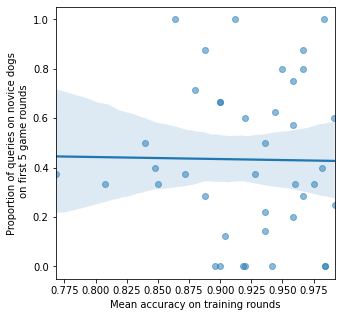

In [100]:
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(x=df['accuracy'], y=df['use'], scatter_kws={'alpha':0.5})
ax.set_xlabel('Mean accuracy on training rounds')
ax.set_ylabel('Proportion of queries on novice dogs\n on first 5 game rounds')


In [101]:
r, p = stats.pearsonr(df['accuracy'],df['use'])
print("Pearson correlation accuracy vs. number of queries:", r)
print("Significance:", p)
print("Number of data points:", df.shape[0])

Pearson correlation accuracy vs. number of queries: -0.01379402679983105
Significance: 0.9326759181164558
Number of data points: 40


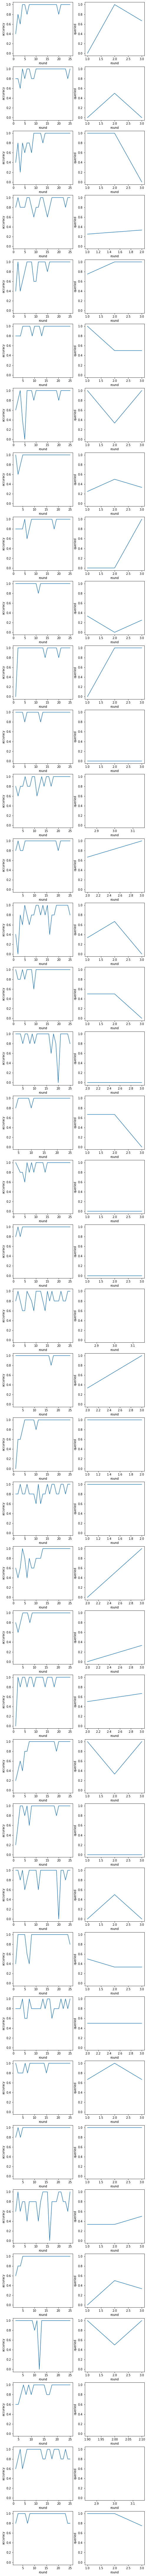

In [102]:
players = training_dyads.player.unique()
fig, axes = plt.subplots(len(players), 2, figsize=(8,4*len(players)))
for i, player in enumerate(players):
    df_player = training_dyads[training_dyads['player'] == player][['round', 'accuracy']]
    df_player = df_player.groupby('round')['accuracy'].mean().reset_index()
    sns.lineplot(x='round', y='accuracy', data=df_player, ax=axes[i, 0])
    df_player = game_dyads[game_dyads['player'] == player][['round', 'queried']]
    df_player = df_player.groupby('round')['queried'].mean().reset_index()
    sns.lineplot(x='round', y='queried', data=df_player, ax=axes[i, 1])
    axes[i, 0].set_ylim([-0.05,1.05])
    axes[i, 1].set_ylim([-0.05,1.05])


# Novatos en terriers

<AxesSubplot:xlabel='accuracy', ylabel='use'>

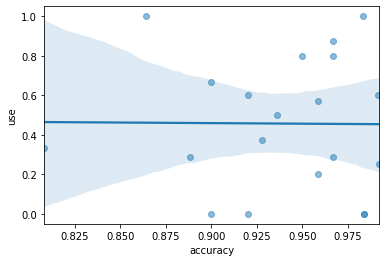

In [103]:
dfr = df[df['novice_in']=='terrier']
sns.regplot(x=dfr['accuracy'], y=dfr['use'], scatter_kws={'alpha':0.5})


In [104]:
r, p = stats.pearsonr(dfr['accuracy'],dfr['use'])
print("Pearson correlation accuracy vs. number of queries:", r)
print("Significance:", p)
print("Number of data points:", df.shape[0])

Pearson correlation accuracy vs. number of queries: -0.008391639975837029
Significance: 0.971990017920995
Number of data points: 40


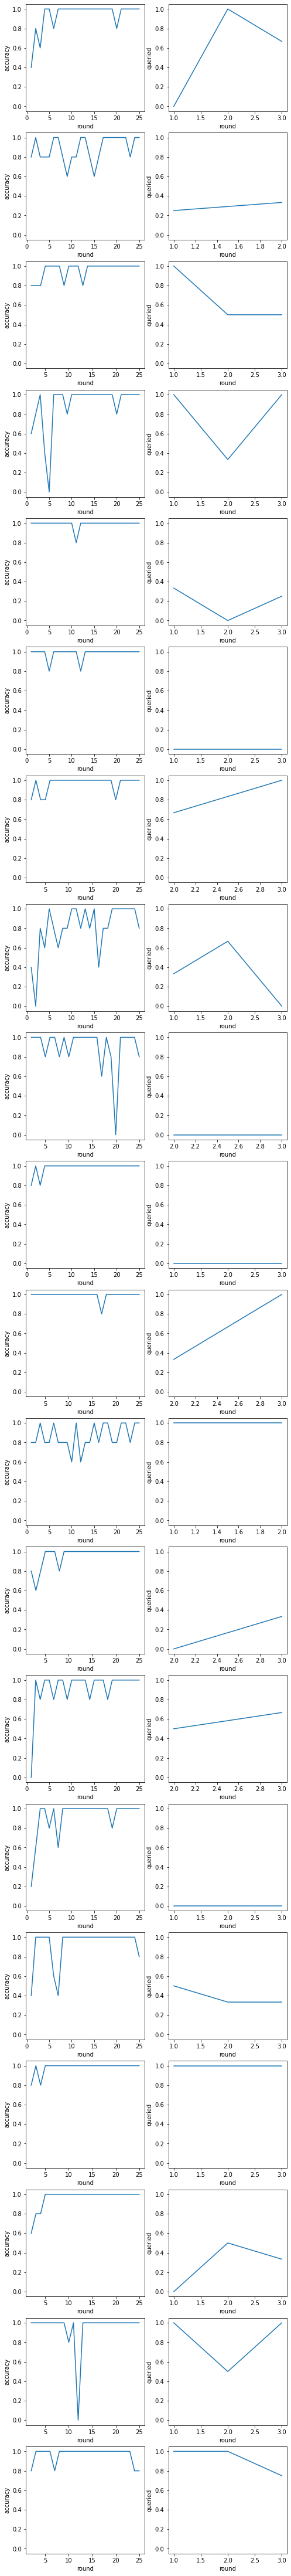

In [105]:
players = training_dyads.player.unique()
novice_terrier = training_dyads[training_dyads['novice_in'] == 'terrier']['player'].unique()
fig, axes = plt.subplots(len(novice_terrier), 2, figsize=(8,4*len(novice_terrier)))
for i, player in enumerate(novice_terrier):
    df_player = training_dyads[training_dyads['player'] == player][['round', 'accuracy']]
    df_player = df_player.groupby('round')['accuracy'].mean().reset_index()
    sns.lineplot(x='round', y='accuracy', data=df_player, ax=axes[i, 0])
    df_player = game_dyads[game_dyads['player'] == player][['round', 'queried']]
    df_player = df_player.groupby('round')['queried'].mean().reset_index()
    sns.lineplot(x='round', y='queried', data=df_player, ax=axes[i, 1])
    axes[i, 0].set_ylim([-0.05,1.05])
    axes[i, 1].set_ylim([-0.05,1.05])

# Novatos en hounds

<AxesSubplot:xlabel='accuracy', ylabel='use'>

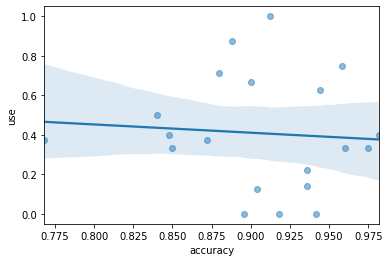

In [106]:
dfr = df[df['novice_in']=='hound']
sns.regplot(x=dfr['accuracy'], y=dfr['use'], scatter_kws={'alpha':0.5})


In [107]:
r, p = stats.pearsonr(dfr['accuracy'],dfr['use'])
print("Pearson correlation accuracy vs. number of queries:", r)
print("Significance:", p)
print("Number of data points:", df.shape[0])

Pearson correlation accuracy vs. number of queries: -0.07595239116732345
Significance: 0.7502890012801854
Number of data points: 40


In [108]:
training_dyads.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
10955,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,B,NaN,B,1,NaN,NaN,NaN
10956,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,D,NaN,B,0,NaN,NaN,NaN
10957,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,D,NaN,D,1,NaN,NaN,NaN
10958,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,B,NaN,D,0,NaN,NaN,NaN
10959,dyad,45981-38174,459819203408978,hound,terrier,Training rounds,1,D,NaN,B,0,NaN,NaN,NaN


In [109]:
df_cor = game_dyads.groupby(['player', 'kind']).agg({'queried':'mean', 'accuracy':'mean'}).reset_index()
df_cor.head()

,player,kind,queried,accuracy
0,21409433577947,B,1.000000,0.00
1,21409433577947,D,0.000000,0.00
2,32111755046981,A,0.400000,0.40
3,32111755046981,C,0.250000,0.75
4,38174543864515,B,0.166667,0.50


<AxesSubplot:xlabel='queried', ylabel='accuracy'>

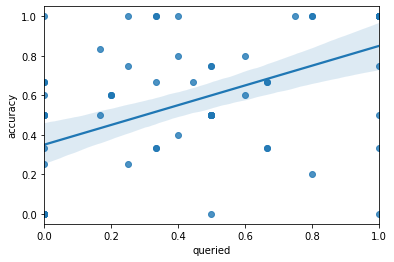

In [110]:
sns.regplot(x='queried', y='accuracy', data=df_cor)

# Indice de cohesión

In [282]:
game_dyads = filter_variables(data, {
    'treatment==':'dyad', 
    'stage==':'Game rounds',
    'expert_dog==':False
})
game_dyads['queried'] = game_dyads['queried'].apply(lambda x: 1 if x>0 else 0)
game_dyads.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
11206,dyad,45981-38174,459819203408978,hound,terrier,Game rounds,1,C,False,A,0,0,NaN,NaN
11209,dyad,45981-38174,459819203408978,hound,terrier,Game rounds,1,A,False,C,0,0,NaN,NaN
11210,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,B,1,0,NaN,NaN
11212,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,D,0,0,NaN,NaN
11213,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,D,0,0,NaN,NaN


In [283]:
df_cohe = game_dyads.groupby(['dyad', 'player', 'round']).agg({'queried':['sum', 'count']}).reset_index()
df_cohe.columns = ['dyad', 'player', 'round', 'sum', 'count']
df_cohe.head()

,dyad,player,round,sum,count
0,10101-83343,101017895939220,1,0,2
1,10101-83343,101017895939220,2,0,1
2,10101-83343,101017895939220,3,0,3
3,10101-83343,101017895939220,4,0,1
4,10101-83343,101017895939220,5,0,3


In [284]:
df_cohe = df_cohe.groupby(['dyad', 'player']).agg({'sum':'sum', 'count':'sum'}).reset_index()
df_cohe['use'] = df_cohe['sum'] / df_cohe['count']
df_cohe = df_cohe[['dyad', 'player', 'use']]
df_cohe.head()

,dyad,player,use
0,10101-83343,101017895939220,0.000000
1,10101-83343,833437527724022,0.000000
2,12379-51238,123795257479166,0.229508
3,12379-51238,512381829158551,0.578125
4,13364-56585,56585762474570,0.760000


In [285]:
usos = {}
usos_partner = {}
for d, grp in df_cohe.groupby('dyad'):
    players = grp.player.to_list()
    l = grp['use'].to_list()
    d = dict(zip(players, l))
    usos_partner[players[0]] = l[1]
    usos_partner[players[1]] = l[0]
    usos.update(d)

print(usos)
print(usos_partner)



{101017895939220: 0.0, 833437527724022: 0.0, 123795257479166: 0.22950819672131148, 512381829158551: 0.578125, 56585762474570: 0.76, 133644391566106: 0.9411764705882353, 137619579400459: 0.25757575757575757, 835804561913525: 0.15254237288135594, 153498218008918: 0.7272727272727273, 951034904396380: 0.6440677966101694, 180672638373464: 0.3088235294117647, 919215741319732: 0.2777777777777778, 235859731771768: 0.44285714285714284, 522058605648886: 0.78, 21409433577947: 0.6428571428571429, 281417746344637: 0.41935483870967744, 32111755046981: 0.09836065573770492, 696092780970702: 0.046875, 42404690668940: 0.7719298245614035, 277030367725057: 0.8970588235294118, 38174543864515: 0.5972222222222222, 459819203408978: 0.660377358490566, 563641349706418: 0.016666666666666666, 668507302070680: 0.423728813559322, 563859218939246: 0.15789473684210525, 939838105107843: 0.3225806451612903, 760791662383499: 0.7966101694915254, 874807326893128: 0.9482758620689655, 765625247183286: 0.0, 845030447613389: 

In [286]:
df_cohe['partner_use'] = df_cohe['player'].map(usos_partner)
df_cohe.head()

,dyad,player,use,partner_use
0,10101-83343,101017895939220,0.000000,0.000000
1,10101-83343,833437527724022,0.000000,0.000000
2,12379-51238,123795257479166,0.229508,0.578125
3,12379-51238,512381829158551,0.578125,0.229508
4,13364-56585,56585762474570,0.760000,0.941176


In [287]:
from scipy.stats import hmean 

In [290]:
df_cohe['dyad_use'] = (df_cohe['use'] + df_cohe['partner_use']) / 2
df_cohe['use_uniform'] = 1 - np.abs(df_cohe['use'] - df_cohe['partner_use'])
df_cohe['cohesion'] = df_cohe.apply(lambda x: hmean([x['dyad_use'], x['use_uniform']]), axis=1)
df_cohe.head(20)


,dyad,player,use,partner_use,dyad_use,use_uniform,cohesion
0,10101-83343,101017895939220,0.000000,0.000000,0.000000,1.000000,0.000000
1,10101-83343,833437527724022,0.000000,0.000000,0.000000,1.000000,0.000000
2,12379-51238,123795257479166,0.229508,0.578125,0.403817,0.651383,0.498558
3,12379-51238,512381829158551,0.578125,0.229508,0.403817,0.651383,0.498558
4,13364-56585,56585762474570,0.760000,0.941176,0.850588,0.818824,0.834404
5,13364-56585,133644391566106,0.941176,0.760000,0.850588,0.818824,0.834404
6,13761-83580,137619579400459,0.257576,0.152542,0.205059,0.894967,0.333667
7,13761-83580,835804561913525,0.152542,0.257576,0.205059,0.894967,0.333667
8,15349-95103,153498218008918,0.727273,0.644068,0.685670,0.916795,0.784565
9,15349-95103,951034904396380,0.644068,0.727273,0.685670,0.916795,0.784565


In [291]:
df_cohe['cohesion'].describe()

count    40.000000
mean      0.458030
std       0.306081
min       0.000000
25%       0.170965
50%       0.411726
75%       0.760530
max       0.963539
Name: cohesion, dtype: float64

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cohesion', ylabel='Density'>

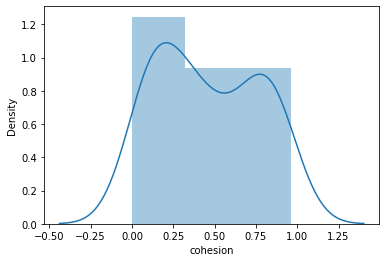

In [292]:
sns.distplot(df_cohe['cohesion'])

In [293]:
df_cohe['cohesion_level'] = pd.cut(df_cohe['cohesion'], 
                                   bins=[0, 0.17, 0.41, 0.76, 1], 
                                   include_lowest=True, 
                                   labels=['very_low', 'low', 'mid', 'high'])
df_cohe.head()

,dyad,player,use,partner_use,dyad_use,use_uniform,cohesion,cohesion_level
0,10101-83343,101017895939220,0.000000,0.000000,0.000000,1.000000,0.000000,very_low
1,10101-83343,833437527724022,0.000000,0.000000,0.000000,1.000000,0.000000,very_low
2,12379-51238,123795257479166,0.229508,0.578125,0.403817,0.651383,0.498558,mid
3,12379-51238,512381829158551,0.578125,0.229508,0.403817,0.651383,0.498558,mid
4,13364-56585,56585762474570,0.760000,0.941176,0.850588,0.818824,0.834404,high


In [296]:
dict_coh = dict(zip(df_cohe['player'], df_cohe['cohesion']))
dict_coh_level = dict(zip(df_cohe['player'], df_cohe['cohesion_level']))

In [294]:
report_understanding = pd.read_csv('rep-understanding.csv')
report_understanding.head()

,treatment,player,kind,expertise,report,accuracy,queried,answered,player_responded
0,dyad,21409433577947,A,experts,7.0,0.931034,2,0.750000,0.941176
1,dyad,21409433577947,B,novices,7.0,0.828571,22,0.954545,NaN
2,dyad,21409433577947,C,experts,1.0,0.100000,1,1.000000,0.888889
3,dyad,21409433577947,D,novices,7.0,0.571429,14,1.000000,NaN
4,dyad,32111755046981,A,novices,5.0,0.678571,3,0.666667,NaN


In [321]:
reportes_novatos = filter_variables(report_understanding, {
    'treatment==':'dyad',
    'expertise==':'novices'
})
reportes_novatos['cohesion'] = reportes_novatos['player'].map(dict_coh)
reportes_novatos['cohesion_level'] = reportes_novatos['player'].map(dict_coh_level)
#reportes_novatos = reportes_novatos[['player', 'report', 'cohesion', 'cohesion_level']]
reportes_novatos.head()

,treatment,player,kind,expertise,report,accuracy,queried,answered,player_responded,cohesion,cohesion_level
1,dyad,21409433577947,B,novices,7.0,0.828571,22,0.954545,NaN,0.630776,mid
3,dyad,21409433577947,D,novices,7.0,0.571429,14,1.000000,NaN,0.630776,mid
4,dyad,32111755046981,A,novices,5.0,0.678571,3,0.666667,NaN,0.134907,very_low
6,dyad,32111755046981,C,novices,4.0,0.757576,3,1.000000,NaN,0.134907,very_low
9,dyad,38174543864515,B,novices,3.0,0.888889,20,1.000000,NaN,0.752518,mid


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='report', ylabel='Density'>

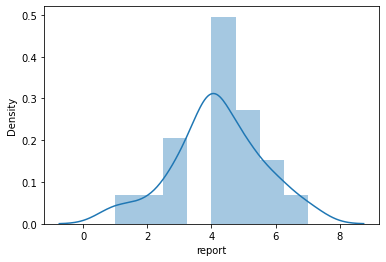

In [320]:
sns.distplot(reportes_novatos['report'])

In [323]:
import statsmodels.formula.api as smf

In [328]:
mod = smf.ols(formula='report ~  accuracy * cohesion', data=reportes_novatos)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 report   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.064
Date:                Tue, 28 Sep 2021   Prob (F-statistic):              0.370
Time:                        17:20:05   Log-Likelihood:                -134.40
No. Observations:                  78   AIC:                             276.8
Df Residuals:                      74   BIC:                             286.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.8239      2.26

<AxesSubplot:xlabel='cohesion', ylabel='report'>

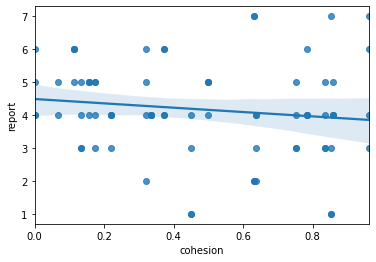

In [313]:
sns.regplot(x='cohesion', y='report', data=reportes_novatos)

In [314]:
r, p = stats.pearsonr(reportes_novatos['report'],reportes_novatos['cohesion'])
print("Pearson correlation accuracy vs. number of queries:", r)
print("Significance:", p)
print("Number of data points:", reportes_novatos.shape[0])

Pearson correlation accuracy vs. number of queries: -0.14252302510872922
Significance: 0.21321530807618977
Number of data points: 78


<AxesSubplot:xlabel='cohesion_level', ylabel='report'>

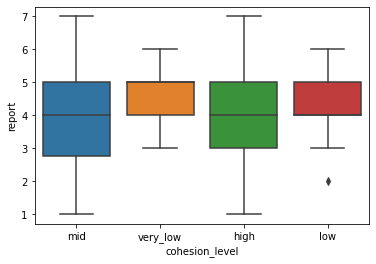

In [303]:
sns.boxplot(x='cohesion_level', y='report', data=reportes_novatos)

In [269]:
from scipy.stats import f_oneway

In [318]:
very_low = reportes_novatos[reportes_novatos['cohesion_level'] == 'very_low']['report']
low = reportes_novatos[reportes_novatos['cohesion_level'] == 'low']['report']
mid = reportes_novatos[reportes_novatos['cohesion_level'] == 'mid']['report']
high = reportes_novatos[reportes_novatos['cohesion_level'] == 'high']['report']
f_oneway(very_low, low, mid, high)

F_onewayResult(statistic=1.7922959374025749, pvalue=0.15603110036766038)

In [319]:
stat, p = stats.ttest_ind(very_low,high)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Reject H0: means are not equal.')
else:
    print('Cannot reject H0: means are equal.')

Statistics=1.421, p=0.164
Cannot reject H0: means are equal.


# Comparación preguntaron vs. no preguntaron

In [246]:
game_dyads = filter_variables(data, {
    'treatment==':'dyad', 
    'stage==':'Game rounds',
    'expert_dog==':False,
    'round<':10
})
game_dyads['queried'] = game_dyads['queried'].apply(lambda x: 1 if x>0 else 0)
game_dyads.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
11206,dyad,45981-38174,459819203408978,hound,terrier,Game rounds,1,C,False,A,0,0,NaN,NaN
11209,dyad,45981-38174,459819203408978,hound,terrier,Game rounds,1,A,False,C,0,0,NaN,NaN
11210,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,B,1,0,NaN,NaN
11212,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,D,0,0,NaN,NaN
11213,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,D,0,0,NaN,NaN


In [247]:
df = game_dyads.groupby(['player', 'round']).agg({'accuracy':'mean'}).reset_index()
df.head()

,player,round,accuracy
0,21409433577947,3,0.000000
1,21409433577947,4,0.333333
2,21409433577947,5,0.333333
3,21409433577947,6,1.000000
4,21409433577947,7,1.000000


In [248]:
df1 = game_dyads.groupby(['player']).agg({'queried':['sum', 'count']}).reset_index()
df1.columns = ['player', 'sum', 'count']
df1['use'] = df1['sum'] / df1['count']
df1.head()

,player,sum,count,use
0,21409433577947,9,19,0.473684
1,32111755046981,4,25,0.160000
2,38174543864515,13,27,0.481481
3,42404690668940,17,22,0.772727
4,56585762474570,14,17,0.823529


In [259]:
df1['use'].describe()

count    40.000000
mean      0.437902
std       0.304394
min       0.000000
25%       0.170435
50%       0.424288
75%       0.702295
max       1.000000
Name: use, dtype: float64

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-2.11583547, -1.7314906 , -1.50271646, -1.33321868, -1.19520249,
         -1.07683093, -0.97189321, -0.87669641, -0.78885043, -0.70670905,
         -0.62908229, -0.55507545, -0.48399287, -0.41527745, -0.34847074,
         -0.28318561, -0.2190868 , -0.15587657, -0.09328369, -0.03105452,
          0.03105452,  0.09328369,  0.15587657,  0.2190868 ,  0.28318561,
          0.34847074,  0.41527745,  0.48399287,  0.55507545,  0.62908229,
          0.70670905,  0.78885043,  0.87669641,  0.97189321,  1.07683093,
          1.19520249,  1.33321868,  1.50271646,  1.7314906 ,  2.11583547]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.1       , 0.10526316, 0.15384615, 0.16      ,
         0.17391304, 0.2       , 0.21052632, 0.31578947, 0.36842105,
         0.36842105, 0.375     , 0.38095238, 0.38461538, 0.4137931 ,
         0.43478261, 0.44444444, 0.47368421, 0.48148148, 0.5       ,
         0.52631579, 0.6       , 0.63636364, 0.68181818, 0.69

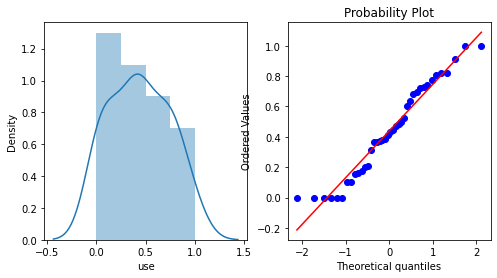

In [258]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
sns.distplot(df1['use'], ax=ax[0])
stats.probplot(df1['use'], dist="norm", plot=ax[1])

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='use', ylabel='Density'>

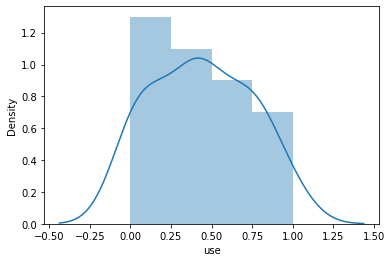

In [261]:
sns.distplot(df1['use'])

In [262]:
df1['active_level'] = pd.cut(df1['use'], 
#                                   bins=[0, 18.5, 100], 
                                   bins=[0, .17, .42, .71, 1], 
                                   include_lowest=True, 
                                   labels=['very_low', 'low', 'medium', 'high'])
df1.head()

,player,sum,count,use,active_level
0,21409433577947,9,19,0.473684,medium
1,32111755046981,4,25,0.160000,very_low
2,38174543864515,13,27,0.481481,medium
3,42404690668940,17,22,0.772727,high
4,56585762474570,14,17,0.823529,high


In [263]:
df1.groupby('active_level')['active_level'].count()

active_level
very_low    10
low         10
medium      10
high        10
Name: active_level, dtype: int64

In [264]:
dict_actilevel = dict(zip(df1['player'], df1['active_level']))
#dict_actilevel

In [265]:
df['active_level'] = df['player'].map(dict_actilevel)
df.head()

,player,round,accuracy,active_level
0,21409433577947,3,0.000000,medium
1,21409433577947,4,0.333333,medium
2,21409433577947,5,0.333333,medium
3,21409433577947,6,1.000000,medium
4,21409433577947,7,1.000000,medium


<AxesSubplot:xlabel='round', ylabel='accuracy'>

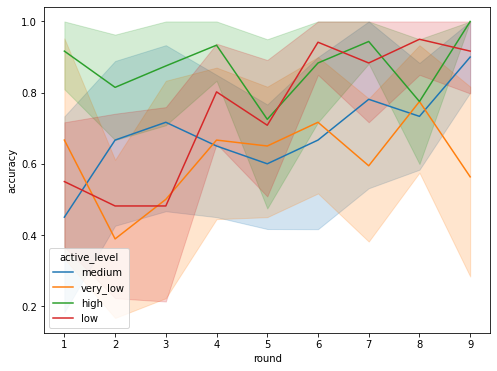

In [266]:
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(hue='active_level', x='round', y='accuracy', data=df, ci=95)

<AxesSubplot:xlabel='active_level', ylabel='accuracy'>

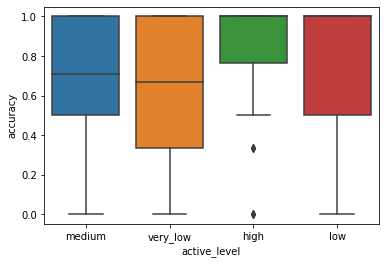

In [267]:
sns.boxplot(x='active_level', y='accuracy', data=df)

In [268]:
l = [k for k in dict_actilevel.keys() if dict_actilevel[k] == 'high']
len(l)

10

In [269]:
from scipy.stats import f_oneway

In [276]:
very_low = df[df['active_level'] == 'very_low']['accuracy']
low = df[df['active_level'] == 'low']['accuracy']
medium = df[df['active_level'] == 'medium']['accuracy']
high = df[df['active_level'] == 'high']['accuracy']
f_oneway(very_low, low, medium, high)

F_onewayResult(statistic=8.77624881847794, pvalue=1.2994960946706095e-05)

In [278]:
stat, p = stats.ttest_ind(very_low,high)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Reject H0: means are not equal.')
else:
    print('Cannot reject H0: means are equal.')

Statistics=-5.051, p=0.000
Reject H0: means are not equal.
